In [166]:
import datetime as dt
from math import ceil, log
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from scipy.stats import norm,skew
from sklearn.preprocessing import OneHotEncoder, StandardScaler,  RobustScaler, LabelEncoder
from sklearn.feature_selection import mutual_info_regression, SelectFromModel
from sklearn.linear_model import LinearRegression, ElasticNetCV, LassoCV, RidgeCV
from sklearn.model_selection import KFold, cross_val_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_squared_log_error




In [190]:
df = pd.read_csv("house_price.csv")
dfr = df
df.head()


,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


<AxesSubplot:>

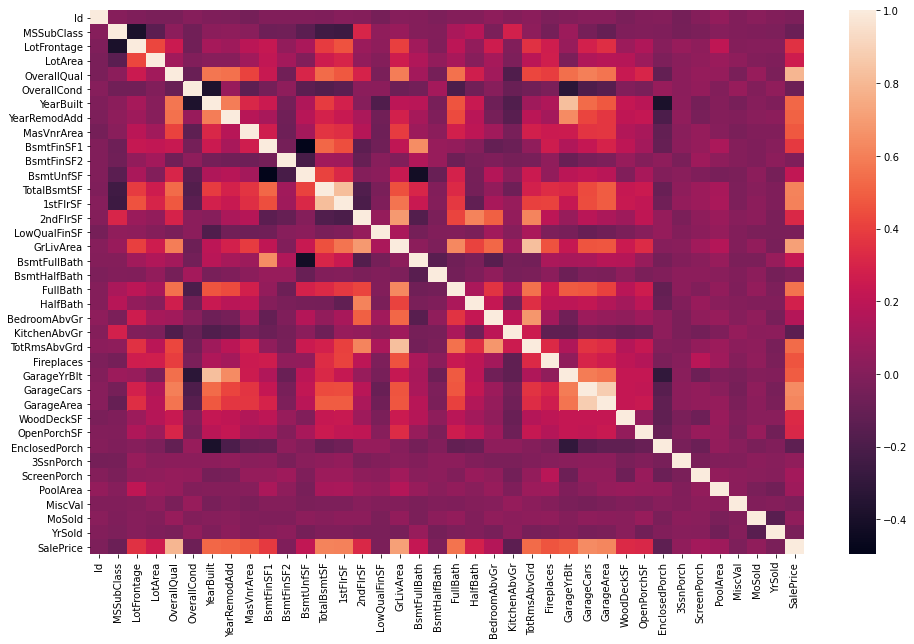

In [191]:
#correlation matrix
corr = df.corr()
f, ax = plt.subplots(figsize=(16, 10))
sns.heatmap(corr)

In [192]:
df.corr()['SalePrice'].sort_values(ascending = False)

SalePrice        1.000000
OverallQual      0.790982
GrLivArea        0.708624
GarageCars       0.640409
GarageArea       0.623431
TotalBsmtSF      0.613581
1stFlrSF         0.605852
FullBath         0.560664
TotRmsAbvGrd     0.533723
YearBuilt        0.522897
YearRemodAdd     0.507101
GarageYrBlt      0.486362
MasVnrArea       0.477493
Fireplaces       0.466929
BsmtFinSF1       0.386420
LotFrontage      0.351799
WoodDeckSF       0.324413
2ndFlrSF         0.319334
OpenPorchSF      0.315856
HalfBath         0.284108
LotArea          0.263843
BsmtFullBath     0.227122
BsmtUnfSF        0.214479
BedroomAbvGr     0.168213
ScreenPorch      0.111447
PoolArea         0.092404
MoSold           0.046432
3SsnPorch        0.044584
BsmtFinSF2      -0.011378
BsmtHalfBath    -0.016844
MiscVal         -0.021190
Id              -0.021917
LowQualFinSF    -0.025606
YrSold          -0.028923
OverallCond     -0.077856
MSSubClass      -0.084284
EnclosedPorch   -0.128578
KitchenAbvGr    -0.135907
Name: SalePr

C:\Users\claudio.parada.veliz\Anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
C:\Users\claudio.parada.veliz\Anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
C:\Users\claudio.parada.veliz\Anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  w

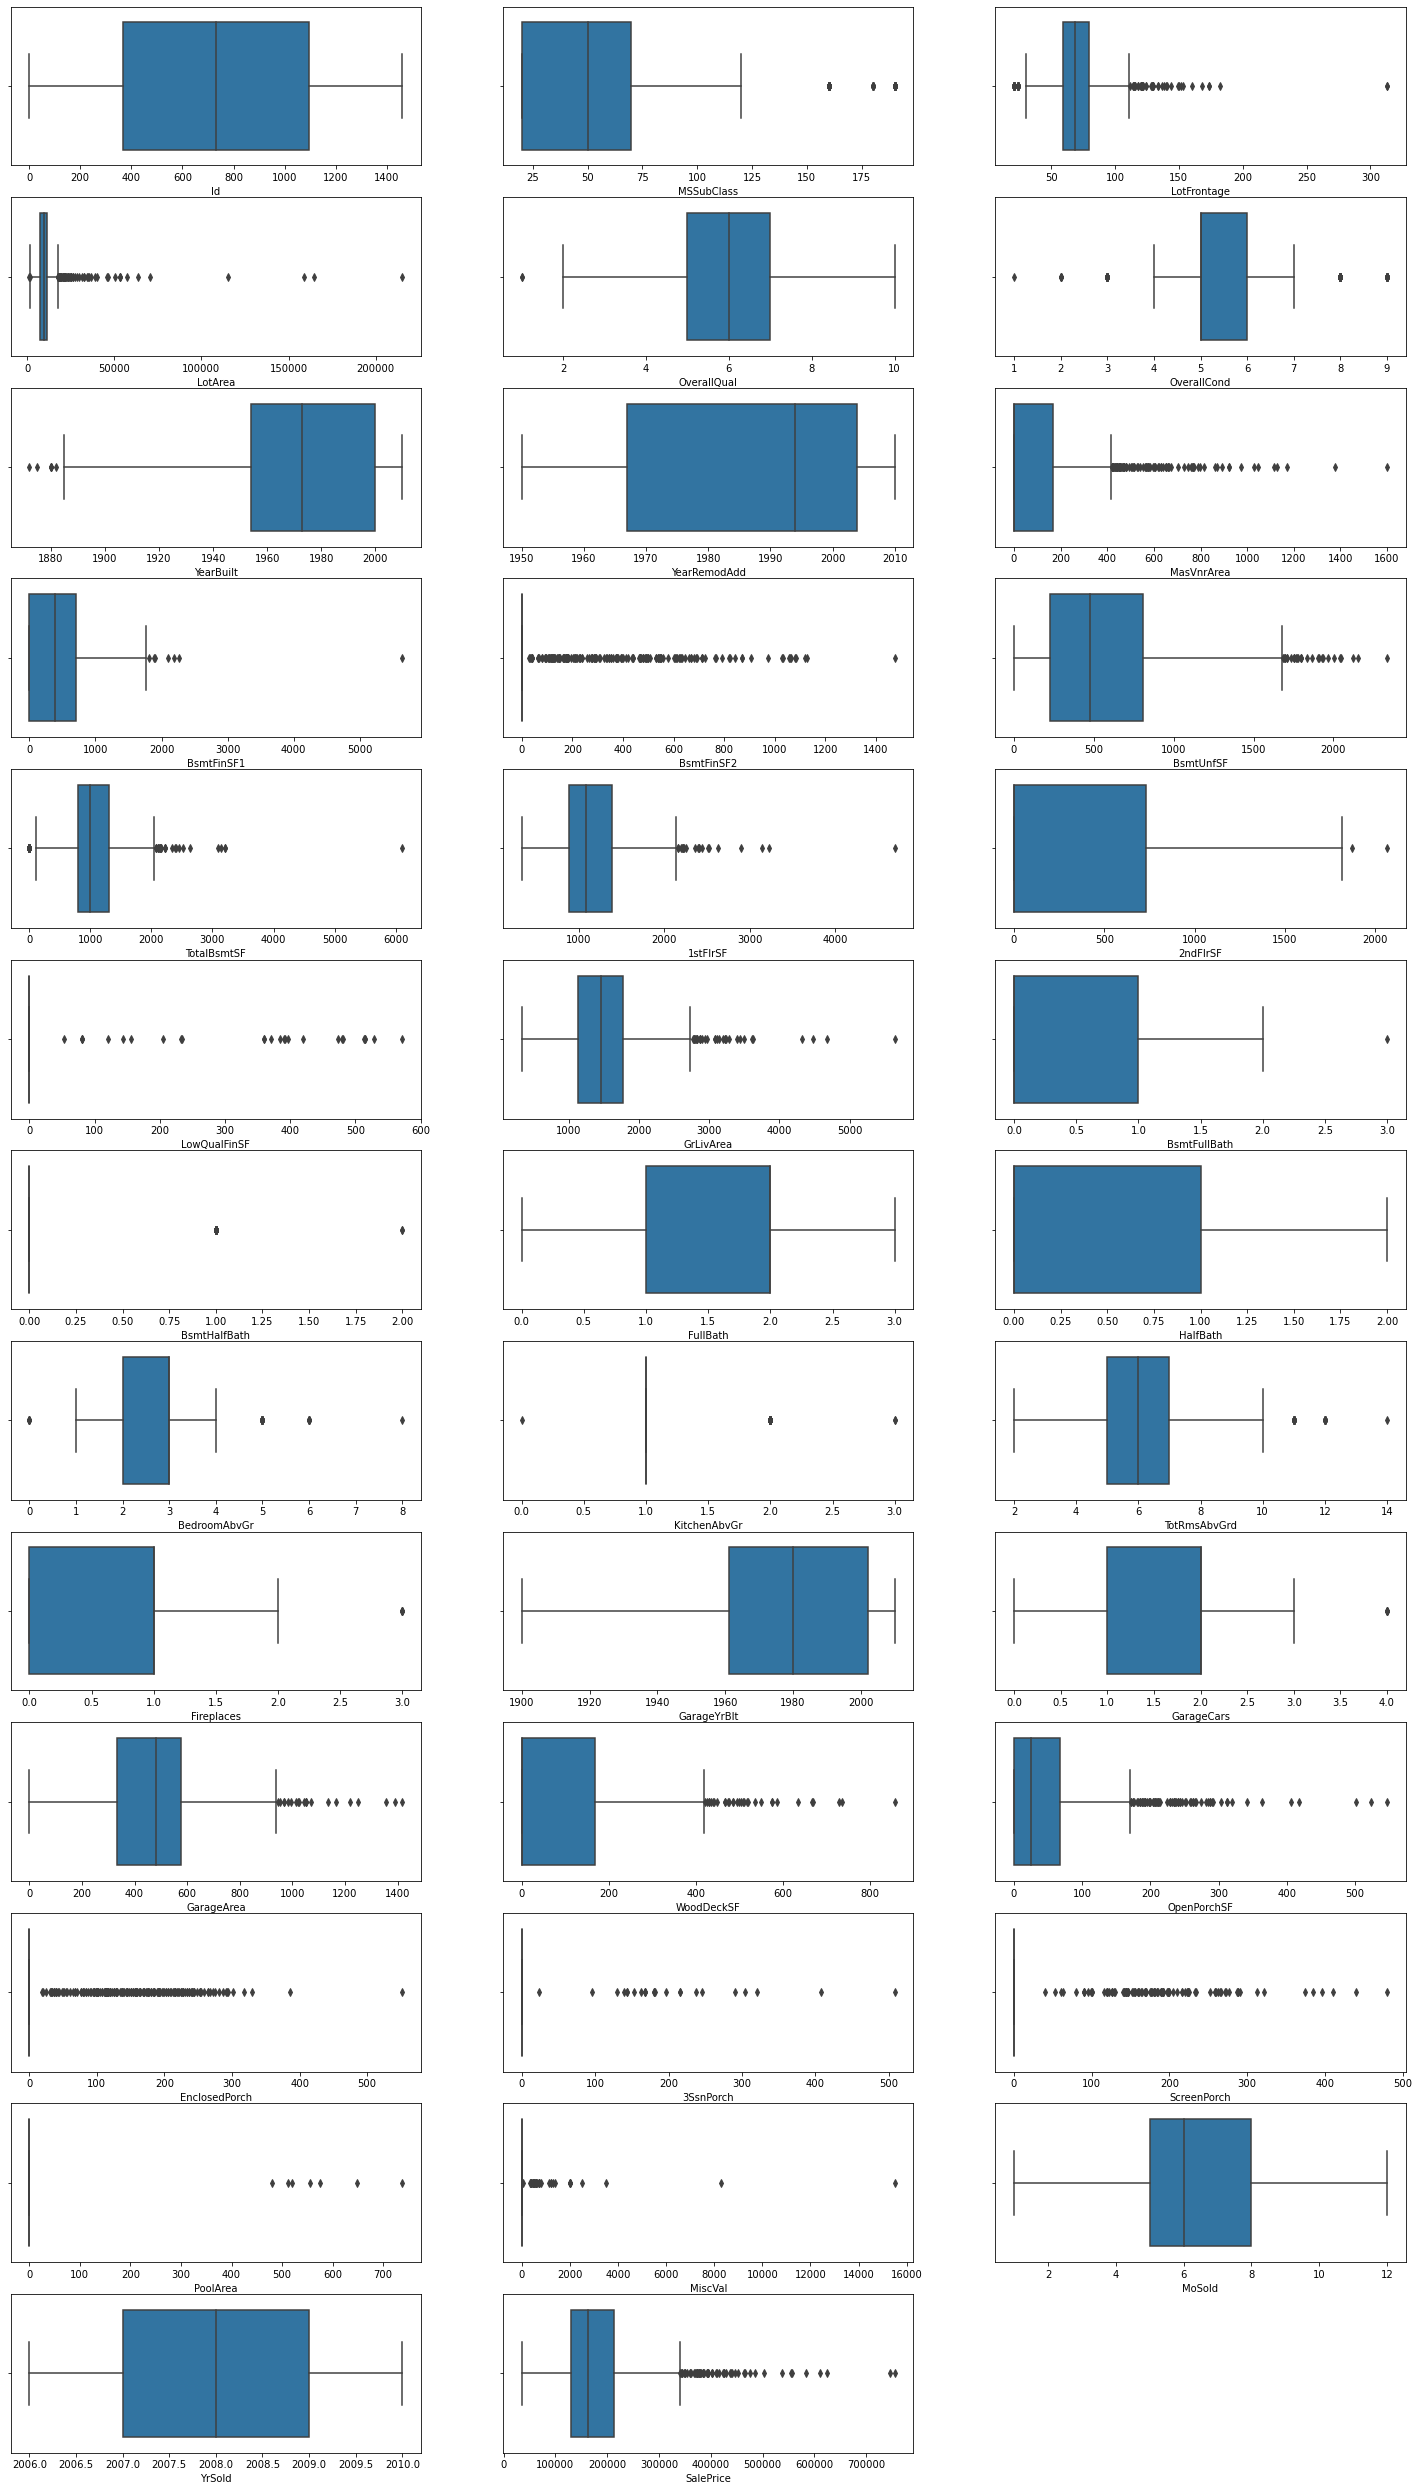

In [193]:
# Drawing box plots to check for outliers

num_cols = df._get_numeric_data().columns 
plt.figure(figsize = (25,45))

for i in enumerate(num_cols):
  plt.subplot(13,3,i[0]+1)
  sns.boxplot(df[i[1]])
  plt.xlabel(i[1])

In [194]:
#Limpieza
df.isnull().sum()[df.isnull().sum() > 0]

LotFrontage      259
Alley           1369
MasVnrType         8
MasVnrArea         8
BsmtQual          37
BsmtCond          37
BsmtExposure      38
BsmtFinType1      37
BsmtFinType2      38
Electrical         1
FireplaceQu      690
GarageType        81
GarageYrBlt       81
GarageFinish      81
GarageQual        81
GarageCond        81
PoolQC          1453
Fence           1179
MiscFeature     1406
dtype: int64

In [195]:
#Creating a list of columns to be removed 

drop_columns = ['Alley', 'PoolQC', 'Fence', 'MiscFeature', 'Id','SalePrice' ]
df = df.drop(drop_columns, axis =1)

print("Shape of data:", df.shape)


Shape of data: (1460, 75)


In [196]:
#Analysing the null data

Null_data = df[['LotFrontage', 'FireplaceQu', 'MasVnrType', 'MasVnrArea', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1',
      'BsmtFinType2', 'Electrical',  'FireplaceQu','GarageType', 'GarageYrBlt', 'GarageFinish', 'GarageQual', 'GarageCond']]

In [197]:
#Creating a function with name 'analysis' for extracting data type, unique and null count

def analysis(data):
    return pd.DataFrame({"Data Type":data.dtypes, "Unique Count":data.apply(lambda x: x.nunique(),axis=0), 
                         "Null Count": data.isnull().sum() })

In [198]:
analysis(Null_data)

,Data Type,Unique Count,Null Count
LotFrontage,float64,110,259
FireplaceQu,object,5,690
MasVnrType,object,4,8
MasVnrArea,float64,327,8
BsmtQual,object,4,37
BsmtCond,object,4,37
BsmtExposure,object,4,38
BsmtFinType1,object,6,37
BsmtFinType2,object,6,38
Electrical,object,5,1


In [199]:
#Lets understand the distribution on the integer values

Null_data[['LotFrontage', 'MasVnrArea', 'GarageYrBlt']].describe()

,LotFrontage,MasVnrArea,GarageYrBlt
count,1201.000000,1452.000000,1379.000000
mean,70.049958,103.685262,1978.506164
std,24.284752,181.066207,24.689725
min,21.000000,0.000000,1900.000000
25%,59.000000,0.000000,1961.000000
50%,69.000000,0.000000,1980.000000
75%,80.000000,166.000000,2002.000000
max,313.000000,1600.000000,2010.000000


In [200]:
#Replacing numeric Null vlaues for training set

df['LotFrontage'] = df['LotFrontage'].fillna((df['LotFrontage'].mean()))
df['MasVnrArea'] = df['MasVnrArea'].fillna((df['MasVnrArea'].mode()[0]))
df['GarageYrBlt'] = df['GarageYrBlt'].fillna((df['GarageYrBlt'].mode()[0]))

In [201]:
# Creating a function to filter records with mode correlation

def correlation(data, limit):
  col = set()
  corr_matrix = data.corr()
  for i in range(len(corr_matrix)):
    for j in range(i):
      if (corr_matrix.iloc[i, j]) > limit:
        col_name = corr_matrix.columns[i]
        col.add(col_name)
  return col


In [202]:
# Getting correlated columns 

corr_columns = correlation(df, 0.7)
corr_columns

{'1stFlrSF', 'GarageArea', 'GarageYrBlt', 'TotRmsAbvGrd'}

In [203]:
#Dropping MiscFeature and MiscVal as their contribution towards the sale values doesnt seem much

df = df.drop(['1stFlrSF', 'GarageArea','GarageYrBlt', 'TotRmsAbvGrd'], axis = 1)
df.head()

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,LotShape,LandContour,Utilities,LotConfig,LandSlope,...,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,60,RL,65.0,8450,Pave,Reg,Lvl,AllPub,Inside,Gtl,...,61,0,0,0,0,0,2,2008,WD,Normal
1,20,RL,80.0,9600,Pave,Reg,Lvl,AllPub,FR2,Gtl,...,0,0,0,0,0,0,5,2007,WD,Normal
2,60,RL,68.0,11250,Pave,IR1,Lvl,AllPub,Inside,Gtl,...,42,0,0,0,0,0,9,2008,WD,Normal
3,70,RL,60.0,9550,Pave,IR1,Lvl,AllPub,Corner,Gtl,...,35,272,0,0,0,0,2,2006,WD,Abnorml
4,60,RL,84.0,14260,Pave,IR1,Lvl,AllPub,FR2,Gtl,...,84,0,0,0,0,0,12,2008,WD,Normal


In [204]:
#Generacion de new columns 

df['YrBltRemod'] = df['YearBuilt'] + df['YearRemodAdd']
df['TotalBathrooms'] = (df['FullBath'] + (0.5 * df['HalfBath']) +
                               df['BsmtFullBath'] + (0.5 * df['BsmtHalfBath']))
df['TotalPorchSf'] = (df['OpenPorchSF'] + df['3SsnPorch'] +
                              df['EnclosedPorch'] + df['ScreenPorch'] +
                              df['WoodDeckSF'])

df["TotalOutsideSF"] = sum((df['WoodDeckSF'],df['OpenPorchSF'],df['EnclosedPorch'], df['ScreenPorch']))

df['HouseAge'] = df['YrSold'] - df['YearBuilt']

df['OverallCondQual'] = (df['OverallCond'] + df['OverallQual'])/2

In [205]:
df_num_c = df._get_numeric_data().columns 
df_num_c

Index(['MSSubClass', 'LotFrontage', 'LotArea', 'OverallQual', 'OverallCond',
       'YearBuilt', 'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2',
       'BsmtUnfSF', 'TotalBsmtSF', '2ndFlrSF', 'LowQualFinSF', 'GrLivArea',
       'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath', 'BedroomAbvGr',
       'KitchenAbvGr', 'Fireplaces', 'GarageCars', 'WoodDeckSF', 'OpenPorchSF',
       'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea', 'MiscVal',
       'MoSold', 'YrSold', 'YrBltRemod', 'TotalBathrooms', 'TotalPorchSf',
       'TotalOutsideSF', 'HouseAge', 'OverallCondQual'],
      dtype='object')

In [206]:
df_cat_c = df.columns.difference(df_num_c)
df_cat_c

Index(['BldgType', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2',
       'BsmtQual', 'CentralAir', 'Condition1', 'Condition2', 'Electrical',
       'ExterCond', 'ExterQual', 'Exterior1st', 'Exterior2nd', 'FireplaceQu',
       'Foundation', 'Functional', 'GarageCond', 'GarageFinish', 'GarageQual',
       'GarageType', 'Heating', 'HeatingQC', 'HouseStyle', 'KitchenQual',
       'LandContour', 'LandSlope', 'LotConfig', 'LotShape', 'MSZoning',
       'MasVnrType', 'Neighborhood', 'PavedDrive', 'RoofMatl', 'RoofStyle',
       'SaleCondition', 'SaleType', 'Street', 'Utilities'],
      dtype='object')

In [207]:
#separar variables numericas y categoricas
df_num = df.loc[:, df_num_c]
df_cat = df.loc[:, df_cat_c]


In [208]:
# Scalamiento variables numericas 

scal = StandardScaler()
m_df_num_s = scal.fit_transform(df_num)

df_num_s = pd.DataFrame(m_df_num_s, columns = df_num_c)

In [209]:
# Scalamiento variables categoricas 
#from sklearn.preprocessing import  LabelEncoder

df_cat = df_cat.fillna('NA')

Label = LabelEncoder()
df_cat = df_cat.astype(str).apply(Label.fit_transform)

In [210]:
df_num.isnull().sum()

MSSubClass         0
LotFrontage        0
LotArea            0
OverallQual        0
OverallCond        0
YearBuilt          0
YearRemodAdd       0
MasVnrArea         0
BsmtFinSF1         0
BsmtFinSF2         0
BsmtUnfSF          0
TotalBsmtSF        0
2ndFlrSF           0
LowQualFinSF       0
GrLivArea          0
BsmtFullBath       0
BsmtHalfBath       0
FullBath           0
HalfBath           0
BedroomAbvGr       0
KitchenAbvGr       0
Fireplaces         0
GarageCars         0
WoodDeckSF         0
OpenPorchSF        0
EnclosedPorch      0
3SsnPorch          0
ScreenPorch        0
PoolArea           0
MiscVal            0
MoSold             0
YrSold             0
YrBltRemod         0
TotalBathrooms     0
TotalPorchSf       0
TotalOutsideSF     0
HouseAge           0
OverallCondQual    0
dtype: int64

In [211]:
df_num_s.reset_index(drop=True, inplace=True)
df_cat.reset_index(drop=True, inplace=True)

df_n = pd.concat([df_num_s, df_cat], axis = 1)

C:\Users\claudio.parada.veliz\Anaconda3\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


Text(0.5, 1.0, 'SalePrice distribution')

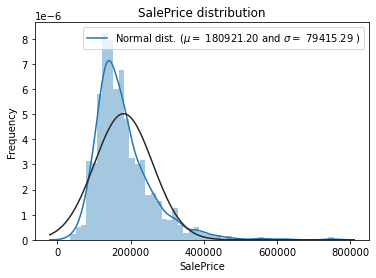

In [212]:
# Revisión de la distribución de probabilidad de SalePrice 
sns.distplot(dfr['SalePrice'] , fit=norm);
(mu, sigma) = norm.fit(dfr['SalePrice'])
plt.legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu, sigma)],
            loc='best')
plt.ylabel('Frequency')
plt.title('SalePrice distribution')

C:\Users\claudio.parada.veliz\Anaconda3\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


Text(0.5, 1.0, 'SalePrice distribution')

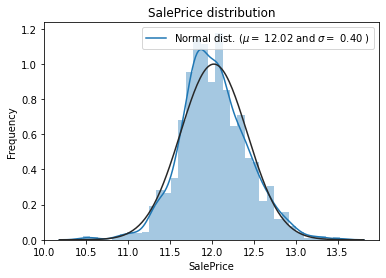

In [213]:
# se transforma con log para normalizar fdp
price = np.log1p(dfr["SalePrice"])
 
sns.distplot(price , fit=norm);
(mu, sigma) = norm.fit(price)
plt.legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu, sigma)],
            loc='best')
plt.ylabel('Frequency')
plt.title('SalePrice distribution')

In [214]:
# Crea conjunto de features (X) y conjunto con etiquetas(y)
y= pd.DataFrame(np.log(dfr['SalePrice']))
#X= df.drop('SalePrice',axis=1)
X=df_n

In [215]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=0)

In [216]:
from sklearn.model_selection import RepeatedKFold
from numpy import absolute
from random import random
from random import randint
from random import seed
from numpy import arange
from numpy import mean
from numpy import std
from matplotlib import pyplot

# evaluate a model
def evaluate_model(X, y, model):
	# define model evaluation method
	cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)
	# evaluate model
	scores = cross_val_score(model, X, y, scoring='neg_mean_absolute_error', cv=cv, n_jobs=-1)
	# force scores to be positive
	return absolute(scores)

In [218]:
#Regresion lineal
from sklearn.metrics import mean_squared_error, mean_squared_log_error

lin_reg = LinearRegression()
lin_reg.fit(X_train, y_train)
pred = lin_reg.predict(X_test)
print(lin_reg.score(X_test, y_test))

results = evaluate_model(X, y, lin_reg)
print('Mean MAE: %.3f (%.3f)' % (mean(results), std(results)))


0.7070554843676546
Mean MAE: 0.102 (0.010)


In [219]:
#Regresion robusta (huber)
from sklearn.linear_model import HuberRegressor

lin_reg = HuberRegressor(max_iter=100000)
lin_reg.fit(X_train, np.ravel(y_train))
pred = lin_reg.predict(X_test)
print(lin_reg.score(X_test, y_test))

results = evaluate_model(X, y, lin_reg)
print('Mean MAE: %.3f (%.3f)' % (mean(results), std(results)))


0.7378870550344594
Mean MAE: 0.089 (0.010)


In [220]:
#Regresion polinomial
from sklearn.metrics import mean_squared_error, mean_squared_log_error
from sklearn.preprocessing import PolynomialFeatures

poly_reg = PolynomialFeatures(degree=4)
X_train_pol = poly_reg.fit_transform(X_train)

pol_reg = LinearRegression()
pol_reg.fit(X_train_pol, y_train)

X_test_pol = poly_reg.fit_transform(X_test)


pred = pol_reg.predict(X_test_pol)
print(pol_reg.score(X_test_pol, y_test))

results = evaluate_model(X, y, pol_reg)
print('Mean MAE: %.3f (%.3f)' % (mean(results), std(results)))


0.7700898192987689
Mean MAE: 0.102 (0.010)


In [1]:
#Penalizacion LASSO
from sklearn import linear_model
lin_reg = linear_model.Lasso(alpha=0.1)
lin_reg.fit(X_train, y_train)
pred = lin_reg.predict(X_test)
print(lin_reg.score(X_test, y_test))

results = evaluate_model(X, y, lin_reg)
print('Mean MAE: %.3f (%.3f)' % (mean(results), std(results)))



NameError: name 'X_train' is not defined

## Implementando las mejores variables al modelo 

In [237]:
df_n = pd.DataFrame(df_n, columns =['YearRemodAdd', 'YearBuilt',  'FullBath',  'TotalBsmtSF', 'GarageCars', '2ndFlrSF', 'GrLivArea', 'OverallQual'])
  

#df_n = df.columns('YearRemodAdd', 'YearBuilt', 'TotRmsAbvGrd', 'FullBath', '1stFlrSF', 'GarageArea', 'TotalBsmtSF', 'GarageCars', '2ndFlrSF', 'GrLivArea', 'OverallQual')
X=df_n
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=0)

In [238]:
df_n.head()

,YearRemodAdd,YearBuilt,FullBath,TotalBsmtSF,GarageCars,2ndFlrSF,GrLivArea,OverallQual
0,0.878668,1.050994,0.789741,-0.459303,0.311725,1.161852,0.370333,0.651479
1,-0.429577,0.156734,0.789741,0.466465,0.311725,-0.795163,-0.482512,-0.071836
2,0.830215,0.984752,0.789741,-0.313369,0.311725,1.189351,0.515013,0.651479
3,-0.720298,-1.863632,-1.026041,-0.687324,1.650307,0.937276,0.383659,0.651479
4,0.733308,0.951632,0.789741,0.199680,1.650307,1.617877,1.299326,1.374795


In [239]:
#Regresion lineal

lin_reg = LinearRegression()
lin_reg.fit(X_train, y_train)
pred = lin_reg.predict(X_test)
print(lin_reg.score(X_test, y_test))

results = evaluate_model(X, y, lin_reg)
print('Mean MAE: %.3f (%.3f)' % (mean(results), std(results)))

0.7450028462809917
Mean MAE: 0.116 (0.010)


In [240]:
#Regresion robusta (huber)
from sklearn.linear_model import HuberRegressor

lin_reg = HuberRegressor(max_iter=100000)
lin_reg.fit(X_train, np.ravel(y_train))
pred = lin_reg.predict(X_test)
print(lin_reg.score(X_test, y_test))

results = evaluate_model(X, y, lin_reg)
print('Mean MAE: %.3f (%.3f)' % (mean(results), std(results)))

0.7357711980162565
Mean MAE: 0.113 (0.011)


In [241]:
#Regresion polinomial
from sklearn.metrics import mean_squared_error, mean_squared_log_error
from sklearn.preprocessing import PolynomialFeatures

poly_reg = PolynomialFeatures(degree=4)
X_train_pol = poly_reg.fit_transform(X_train)

pol_reg = LinearRegression()
pol_reg.fit(X_train_pol, y_train)

X_test_pol = poly_reg.fit_transform(X_test)


pred = pol_reg.predict(X_test_pol)
print(pol_reg.score(X_test_pol, y_test))

results = evaluate_model(X, y, pol_reg)
print('Mean MAE: %.3f (%.3f)' % (mean(results), std(results)))


-337.6676945733401
Mean MAE: 0.116 (0.010)
